In [1]:
import numpy as np
import pandas as pd
from functools import partial
from sklearn.experimental import enable_halving_search_cv
from sklearn.base import clone
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    cross_validate,
    cross_val_predict,
    RandomizedSearchCV,
    HalvingRandomSearchCV,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    make_scorer,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    fbeta_score,
    roc_auc_score,
    average_precision_score,
    log_loss,
    confusion_matrix,
    classification_report,
    precision_recall_curve,
    roc_curve,
)
from xgboost import XGBClassifier
import category_encoders as ce

### Settings

In [2]:
SEED = 1990
TEST_RATIO = 1 / 4

### Train-Test Split

In [3]:
data = pd.read_pickle("classification_dataset.pkl")
X = data.drop("target", axis=1)
y = data["target"]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_RATIO, random_state=SEED, stratify=y
)

In [5]:
y_train.value_counts(normalize=True)

target
0    0.7
1    0.3
Name: proportion, dtype: float64

### Define Pipeline

In [6]:
pipen = Pipeline([("numeric", StandardScaler())])

In [7]:
pipec = Pipeline([("categorical", ce.CatBoostEncoder())])

In [8]:
prepro = ColumnTransformer(
    [
        ("num", pipen, make_column_selector(dtype_include=np.number)),
        ("cat", pipec, make_column_selector(dtype_include=object)),
    ]
)

### Add model to the Pipeline

In [9]:
model = Pipeline([("prp", prepro), ("clf", XGBClassifier())])

### cross_val_score

In [10]:
cvscore1 = cross_val_score(model, X_train, y_train, scoring="f1", cv=3)
cvscore1

array([0.82191781, 0.73291925, 0.75167785])

### cross_validate

In [11]:
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "f1": make_scorer(f1_score),
    "f2": make_scorer(fbeta_score, beta=2),
    "f0.5": make_scorer(fbeta_score, beta=0.5),
    "precision": make_scorer(precision_score),
    "recall": make_scorer(recall_score),
    "roc_auc": make_scorer(roc_auc_score),
    "pr_auc": make_scorer(average_precision_score),
    "log_loss": make_scorer(log_loss),
}

In [12]:
cvscore2 = cross_validate(
    model,
    X_train,
    y_train,
    scoring=scoring,
    cv=3,
    return_train_score=True,
)
cvscore2

{'fit_time': array([0.07668686, 0.03370309, 0.03618717]),
 'score_time': array([0.00866818, 0.00733995, 0.00747395]),
 'test_accuracy': array([0.896, 0.828, 0.852]),
 'train_accuracy': array([0.964, 0.994, 0.982]),
 'test_f1': array([0.82191781, 0.73291925, 0.75167785]),
 'train_f1': array([0.93918919, 0.98996656, 0.9704918 ]),
 'test_f2': array([0.80862534, 0.7642487 , 0.7486631 ]),
 'train_f2': array([0.93163539, 0.98798398, 0.98013245]),
 'test_f0.5': array([0.8356546 , 0.70405728, 0.75471698]),
 'train_f0.5': array([0.94686649, 0.9919571 , 0.96103896]),
 'test_precision': array([0.84507042, 0.68604651, 0.75675676]),
 'train_precision': array([0.95205479, 0.99328859, 0.95483871]),
 'test_recall': array([0.8       , 0.78666667, 0.74666667]),
 'train_recall': array([0.92666667, 0.98666667, 0.98666667]),
 'test_roc_auc': array([0.86857143, 0.81619048, 0.82190476]),
 'train_roc_auc': array([0.95333333, 0.99190476, 0.98333333]),
 'test_pr_auc': array([0.73605634, 0.60368992, 0.64104505])

In [13]:
pd.DataFrame(cvscore2)

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_f2,train_f2,test_f0.5,train_f0.5,test_precision,train_precision,test_recall,train_recall,test_roc_auc,train_roc_auc,test_pr_auc,train_pr_auc,test_log_loss,train_log_loss
0,0.076687,0.008668,0.896,0.964,0.821918,0.939189,0.808625,0.931635,0.835655,0.946866,0.845070,0.952055,0.800000,0.926667,0.868571,0.953333,0.736056,0.904237,3.748540,1.297572
1,0.033703,0.007340,0.828,0.994,0.732919,0.989967,0.764249,0.987984,0.704057,0.991957,0.686047,0.993289,0.786667,0.986667,0.816190,0.991905,0.603690,0.984045,6.199508,0.216262
2,0.036187,0.007474,0.852,0.982,0.751678,0.970492,0.748663,0.980132,0.754717,0.961039,0.756757,0.954839,0.746667,0.986667,0.821905,0.983333,0.641045,0.946108,5.334461,0.648786


### RandomizedSearchCV

* RandomizedSearchCV [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
* this will sample **n_iter** from the params_grid; each grid will be evaluated with cross-validation on **cv** folds
* the output will return the results **cv** results, corresponding to the evaluation on the different folds
* output will contain the test fold(s) results and potentially the train folds - if **return_train_score**
* **refit** : Refit an estimator using the best found parameters on the whole dataset.
* if **refit** is used, the best params_grid examined will be selected based on the **refit** value to train the estimator on the **entire dataset**
* **cv** : For integer/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used. In all other cases, KFold is used. These splitters are instantiated with shuffle=False so the splits will be the same across calls.

In [14]:
params_grid = {
    "clf__n_estimators": [100, 150, 200],
    "clf__learning_rate": [0.01, 0.1, 0.5],
    "clf__max_depth": [3, 5, 7],
    "clf__min_child_weight": [1, 3, 5],
    "clf__subsample": [0.6, 0.8, 1.0],
    "clf__colsample_bytree": [0.6, 0.8, 1.0],
    "clf__gamma": [0, 0.3, 0.5],
    "clf__reg_alpha": [0.1, 0.25, 0.75],
    "clf__reg_lambda": [0.1, 0.25, 0.75],
}

In [15]:
search1 = RandomizedSearchCV(
    estimator=model,
    param_distributions=params_grid,
    n_iter=20,
    scoring=scoring,
    refit="accuracy",
    cv=3,
    verbose=1,
    return_train_score=True,
    random_state=SEED,
)

In [16]:
search1.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('prp',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('numeric',
                                                                                                StandardScaler())]),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x15a907bb0>),
                                                                              ('cat',
                                                                               Pipeline(steps=[('categorical',
                                                                                                CatBoostEncoder())]),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x15...
                   scoring={'accuracy': make_scorer(accuracy_score),
                            'f0.5': make_scorer(fbeta_score, beta=0.5),
                            'f1': make_scorer(f1_score),
                            'f2': make_scorer(fbeta_score, beta=2),
                            'log_loss': make_scorer(log_loss),
                            'pr_auc': make_scorer(average_precision_score),
                            'precision': make_scorer(precision_score),
                            'recall': make_scorer(recall_score),
                            'roc_auc': make_scorer(roc_auc_score)},
                   verbose=1)

In [17]:
[x for x in dir(search1) if not x.startswith('_')]

['best_estimator_',
 'best_index_',
 'best_params_',
 'best_score_',
 'classes_',
 'cv',
 'cv_results_',
 'decision_function',
 'error_score',
 'estimator',
 'feature_names_in_',
 'fit',
 'get_params',
 'inverse_transform',
 'multimetric_',
 'n_features_in_',
 'n_iter',
 'n_jobs',
 'n_splits_',
 'param_distributions',
 'pre_dispatch',
 'predict',
 'predict_log_proba',
 'predict_proba',
 'random_state',
 'refit',
 'refit_time_',
 'return_train_score',
 'score',
 'score_samples',
 'scorer_',
 'scoring',
 'set_params',
 'transform',
 'verbose']

In [18]:
search1.best_estimator_

Pipeline(steps=[('prp',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('numeric',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x15a0e0f40>),
                                                 ('cat',
                                                  Pipeline(steps=[('categorical',
                                                                   CatBoostEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10634d8b0>)])),
                ('clf',
                 XGBClassifier(...
                               feature_types=None, gamma=0, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, predictor=None,
                               random_state=None, ...))])

In [19]:
search1.best_params_

{'clf__subsample': 0.6,
 'clf__reg_lambda': 0.1,
 'clf__reg_alpha': 0.1,
 'clf__n_estimators': 200,
 'clf__min_child_weight': 1,
 'clf__max_depth': 3,
 'clf__learning_rate': 0.01,
 'clf__gamma': 0,
 'clf__colsample_bytree': 0.6}

In [20]:
search1.best_index_

12

In [21]:
search1.best_score_

0.88

In [22]:
search1.cv_results_

{'mean_fit_time': array([0.05614996, 0.05674537, 0.03621348, 0.05003985, 0.04905128,
        0.04927524, 0.06132825, 0.0982333 , 0.09122992, 0.09380666,
        0.02850533, 0.04601518, 0.04472955, 0.04888368, 0.03485163,
        0.05151097, 0.02844906, 0.09120719, 0.04138207, 0.03571733]),
 'std_fit_time': array([0.01583372, 0.01906867, 0.00068062, 0.00078674, 0.00073927,
        0.01150806, 0.02085171, 0.04809876, 0.00062886, 0.05204609,
        0.00259916, 0.00533749, 0.00167083, 0.00387338, 0.00094033,
        0.00181772, 0.00055746, 0.02518351, 0.001623  , 0.00052102]),
 'mean_score_time': array([0.00757305, 0.00744073, 0.00712768, 0.00866779, 0.00715407,
        0.00778858, 0.00735601, 0.00792805, 0.00735005, 0.00795078,
        0.00875926, 0.00726064, 0.00718339, 0.00717998, 0.00718204,
        0.00724912, 0.00700959, 0.00946283, 0.00715844, 0.00867931]),
 'std_score_time': array([4.28623929e-04, 1.95190941e-04, 2.86303114e-05, 1.94201370e-03,
        8.84770316e-05, 1.89179830e-

In [23]:
search1df = pd.DataFrame(search1.cv_results_)
search1df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__subsample,param_clf__reg_lambda,param_clf__reg_alpha,param_clf__n_estimators,param_clf__min_child_weight,param_clf__max_depth,...,split1_test_log_loss,split2_test_log_loss,mean_test_log_loss,std_test_log_loss,rank_test_log_loss,split0_train_log_loss,split1_train_log_loss,split2_train_log_loss,mean_train_log_loss,std_train_log_loss
0,0.056150,0.015834,0.007573,0.000429,1.0,0.75,0.1,150,3,3,...,4.325238,5.046111,4.613588,0.311453,16,3.964802,3.388103,3.604365,3.652424,0.237876
1,0.056745,0.019069,0.007441,0.000195,0.6,0.1,0.25,100,5,5,...,6.343683,5.190286,5.286402,0.826825,6,4.036889,3.892715,3.964802,3.964802,0.058859
2,0.036213,0.000681,0.007128,0.000029,0.6,0.25,0.1,150,1,3,...,6.343683,4.901937,5.238344,0.801290,8,2.090532,0.720873,1.297572,1.369659,0.561479
3,0.050040,0.000787,0.008668,0.001942,0.8,0.75,0.1,150,1,5,...,6.343683,5.334461,5.094170,1.131156,13,1.802183,0.288349,0.865048,0.985193,0.623832
4,0.049051,0.000739,0.007154,0.000088,0.8,0.25,0.25,200,1,3,...,4.469413,4.901937,4.421355,0.413412,19,3.892715,3.460191,3.316016,3.556307,0.245050
5,0.049275,0.011508,0.007789,0.000189,0.8,0.1,0.1,100,1,3,...,4.469413,5.190286,4.565529,0.475752,17,4.253151,3.748540,3.532278,3.844656,0.302041
6,0.061328,0.020852,0.007356,0.000072,0.6,0.25,0.1,200,3,7,...,6.920381,4.613588,5.430577,1.055094,2,2.234707,1.369659,1.585921,1.730095,0.367575
7,0.098233,0.048099,0.007928,0.000700,0.6,0.25,0.25,200,3,7,...,5.911159,4.901937,4.901937,0.824027,15,3.748540,2.739318,3.027667,3.171841,0.424439
8,0.091230,0.000629,0.007350,0.000522,0.6,0.25,0.1,100,3,7,...,5.911159,5.190286,5.382519,0.378411,4,3.676453,2.883492,3.460191,3.340045,0.334687
9,0.093807,0.052046,0.007951,0.000303,0.8,0.75,0.25,200,5,7,...,6.055334,5.190286,5.190286,0.706308,11,3.676453,2.883492,3.316016,3.291987,0.324170


In [24]:
search1df.shape

(20, 113)

In [25]:
search1df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_clf__subsample', 'param_clf__reg_lambda', 'param_clf__reg_alpha',
       'param_clf__n_estimators', 'param_clf__min_child_weight',
       'param_clf__max_depth',
       ...
       'split1_test_log_loss', 'split2_test_log_loss', 'mean_test_log_loss',
       'std_test_log_loss', 'rank_test_log_loss', 'split0_train_log_loss',
       'split1_train_log_loss', 'split2_train_log_loss', 'mean_train_log_loss',
       'std_train_log_loss'],
      dtype='object', length=113)

In [26]:
search1df.filter(like='mean_',axis=1)

,mean_fit_time,mean_score_time,mean_test_accuracy,mean_train_accuracy,mean_test_f1,mean_train_f1,mean_test_f2,mean_train_f2,mean_test_f0.5,mean_train_f0.5,mean_test_precision,mean_train_precision,mean_test_recall,mean_train_recall,mean_test_roc_auc,mean_train_roc_auc,mean_test_pr_auc,mean_train_pr_auc,mean_test_log_loss,mean_train_log_loss
0,0.056150,0.007573,0.872000,0.898667,0.763029,0.816835,0.716586,0.777501,0.816633,0.860403,0.857277,0.892155,0.688889,0.753333,0.819683,0.857143,0.683585,0.746194,4.613588,3.652424
1,0.056745,0.007441,0.853333,0.890000,0.752687,0.811328,0.746183,0.797660,0.759911,0.825654,0.765155,0.835597,0.742222,0.788889,0.821587,0.861111,0.645784,0.722360,5.286402,3.964802
2,0.036213,0.007128,0.854667,0.962000,0.761513,0.935778,0.765617,0.932754,0.758315,0.939490,0.756657,0.942360,0.768889,0.931111,0.830159,0.953175,0.650863,0.898001,5.238344,1.369659
3,0.050040,0.008668,0.858667,0.972667,0.769966,0.954595,0.777039,0.955164,0.763665,0.954050,0.759858,0.953699,0.782222,0.955556,0.836825,0.967778,0.660920,0.925441,5.094170,0.985193
4,0.049051,0.007154,0.877333,0.901333,0.782638,0.824220,0.755028,0.791497,0.812580,0.859825,0.833997,0.885359,0.737778,0.771111,0.837460,0.864127,0.694251,0.751463,4.421355,3.556307
5,0.049275,0.007789,0.873333,0.893333,0.768435,0.805765,0.727098,0.763544,0.815614,0.852944,0.851042,0.887603,0.702222,0.737778,0.824444,0.848889,0.686760,0.733753,4.565529,3.844656
6,0.061328,0.007356,0.849333,0.952000,0.753345,0.919734,0.756919,0.919830,0.750918,0.919826,0.749885,0.919992,0.760000,0.920000,0.823810,0.942857,0.641913,0.870484,5.430577,1.730095
7,0.098233,0.007928,0.864000,0.912000,0.768807,0.846446,0.757775,0.824794,0.781183,0.869584,0.790247,0.885920,0.751111,0.811111,0.831746,0.883175,0.668251,0.775400,4.901937,3.171841
8,0.091230,0.007350,0.850667,0.907333,0.747869,0.839579,0.741615,0.820872,0.754768,0.859230,0.759755,0.872893,0.737778,0.808889,0.818413,0.879206,0.638826,0.763609,5.382519,3.340045
9,0.093807,0.007951,0.856000,0.908667,0.755139,0.840684,0.744405,0.819757,0.766891,0.863330,0.775331,0.879490,0.737778,0.806667,0.822222,0.879524,0.650705,0.767124,5.190286,3.291987


In [27]:
search1df.loc[search1.best_index_]

mean_fit_time             0.04473
std_fit_time             0.001671
mean_score_time          0.007183
std_score_time           0.000021
param_clf__subsample          0.6
                           ...   
split0_train_log_loss    4.036889
split1_train_log_loss    3.243929
split2_train_log_loss    3.676453
mean_train_log_loss      3.652424
std_train_log_loss        0.32417
Name: 12, Length: 113, dtype: object

In [28]:
search1est = search1.best_estimator_

In [29]:
y_pred_train = search1est.predict(X_train)
y_pred_test = search1est.predict(X_test)

In [30]:
print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       525
           1       0.90      0.76      0.82       225

    accuracy                           0.90       750
   macro avg       0.90      0.86      0.88       750
weighted avg       0.90      0.90      0.90       750



In [31]:
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91       175
           1       0.81      0.76      0.79        75

    accuracy                           0.88       250
   macro avg       0.86      0.84      0.85       250
weighted avg       0.87      0.88      0.87       250



### HalvingRandomSearchCV

* HalvingRandomSearchCV [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingRandomSearchCV.html#sklearn.model_selection.HalvingRandomSearchCV)
* The search strategy starts evaluating all the candidates with a small amount of resources and iteratively selects the best candidates, using more and more resources.

In [32]:
search2 = HalvingRandomSearchCV(
    estimator=model,
    n_candidates=200,
    param_distributions=params_grid,
    scoring="accuracy",
    refit=True,
    cv=3,
    verbose=1,
    return_train_score=True,
    random_state=SEED,
)

In [33]:
search2.fit(X_train,y_train)

n_iterations: 4
n_required_iterations: 5
n_possible_iterations: 4
min_resources_: 12
max_resources_: 750
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 200
n_resources: 12
Fitting 3 folds for each of 200 candidates, totalling 600 fits
----------
iter: 1
n_candidates: 67
n_resources: 36
Fitting 3 folds for each of 67 candidates, totalling 201 fits
----------
iter: 2
n_candidates: 23
n_resources: 108
Fitting 3 folds for each of 23 candidates, totalling 69 fits
----------
iter: 3
n_candidates: 8
n_resources: 324
Fitting 3 folds for each of 8 candidates, totalling 24 fits


HalvingRandomSearchCV(cv=3,
                      estimator=Pipeline(steps=[('prp',
                                                 ColumnTransformer(transformers=[('num',
                                                                                  Pipeline(steps=[('numeric',
                                                                                                   StandardScaler())]),
                                                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x15a907bb0>),
                                                                                 ('cat',
                                                                                  Pipeline(steps=[('categorical',
                                                                                                   CatBoostEncoder())]),
                                                                                  <sklearn.compose._column_transformer.make_column_selector object at 0...
                      param_distributions={'clf__colsample_bytree': [0.6, 0.8,
                                                                     1.0],
                                           'clf__gamma': [0, 0.3, 0.5],
                                           'clf__learning_rate': [0.01, 0.1,
                                                                  0.5],
                                           'clf__max_depth': [3, 5, 7],
                                           'clf__min_child_weight': [1, 3, 5],
                                           'clf__n_estimators': [100, 150, 200],
                                           'clf__reg_alpha': [0.1, 0.25, 0.75],
                                           'clf__reg_lambda': [0.1, 0.25, 0.75],
                                           'clf__subsample': [0.6, 0.8, 1.0]},
                      random_state=1990, scoring='accuracy', verbose=1)

In [34]:
[x for x in dir(search2) if not x.startswith('_')]

['aggressive_elimination',
 'best_estimator_',
 'best_index_',
 'best_params_',
 'best_score_',
 'classes_',
 'cv',
 'cv_results_',
 'decision_function',
 'error_score',
 'estimator',
 'factor',
 'feature_names_in_',
 'fit',
 'get_params',
 'inverse_transform',
 'max_resources',
 'max_resources_',
 'min_resources',
 'min_resources_',
 'multimetric_',
 'n_candidates',
 'n_candidates_',
 'n_features_in_',
 'n_iterations_',
 'n_jobs',
 'n_possible_iterations_',
 'n_remaining_candidates_',
 'n_required_iterations_',
 'n_resources_',
 'n_splits_',
 'param_distributions',
 'pre_dispatch',
 'predict',
 'predict_log_proba',
 'predict_proba',
 'random_state',
 'refit',
 'refit_time_',
 'resource',
 'return_train_score',
 'score',
 'score_samples',
 'scorer_',
 'scoring',
 'set_params',
 'transform',
 'verbose']

In [35]:
search2.best_score_

0.8672839506172839

In [36]:
search2.best_params_

{'clf__subsample': 1.0,
 'clf__reg_lambda': 0.25,
 'clf__reg_alpha': 0.75,
 'clf__n_estimators': 200,
 'clf__min_child_weight': 1,
 'clf__max_depth': 3,
 'clf__learning_rate': 0.1,
 'clf__gamma': 0,
 'clf__colsample_bytree': 0.8}

In [52]:
pd.DataFrame(search2.cv_results_)

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__subsample,param_clf__reg_lambda,param_clf__reg_alpha,param_clf__n_estimators,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0,12,0.022312,0.008552,0.004097,0.001353,0.6,0.75,0.75,100,...,0.750000,0.250000,0.583333,0.235702,99,0.750000,0.750000,0.750000,0.750000,0.000000
1,0,12,0.015013,0.001349,0.003004,0.000062,1.0,0.75,0.1,150,...,0.750000,0.250000,0.583333,0.235702,99,0.750000,0.750000,0.750000,0.750000,0.000000
2,0,12,0.020123,0.007958,0.003083,0.000192,1.0,0.1,0.1,150,...,0.750000,0.250000,0.583333,0.235702,99,0.750000,0.750000,0.750000,0.750000,0.000000
3,0,12,0.012448,0.000723,0.002981,0.000018,0.8,0.1,0.75,100,...,0.750000,0.250000,0.583333,0.235702,99,0.750000,0.750000,0.750000,0.750000,0.000000
4,0,12,0.018500,0.000980,0.002979,0.000018,1.0,0.75,0.75,200,...,0.750000,0.250000,0.583333,0.235702,99,0.750000,0.750000,0.750000,0.750000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,3,324,0.036423,0.003530,0.003159,0.000026,1.0,0.25,0.75,200,...,0.805556,0.870370,0.867284,0.049189,1,0.953704,0.981481,0.972222,0.969136,0.011548
294,3,324,0.034153,0.002307,0.003136,0.000060,0.6,0.1,0.1,200,...,0.768519,0.805556,0.817901,0.046193,8,0.907407,0.898148,0.875000,0.893519,0.013629
295,3,324,0.030263,0.000187,0.003340,0.000388,0.6,0.25,0.1,200,...,0.787037,0.824074,0.833333,0.042093,7,0.944444,0.930556,0.953704,0.942901,0.009513
296,3,324,0.049691,0.002705,0.003306,0.000038,0.8,0.75,0.1,200,...,0.824074,0.833333,0.854938,0.037293,4,0.935185,0.953704,0.935185,0.941358,0.008730


### Inject Hyperparams to model

In [46]:
cpmodel = clone(model)

In [47]:
cpmodel.named_steps['clf']

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [48]:
cpmodel.set_params(**search1.best_params_)

Pipeline(steps=[('prp',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('numeric',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x15a9d5730>),
                                                 ('cat',
                                                  Pipeline(steps=[('categorical',
                                                                   CatBoostEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x15aa56d30>)])),
                ('clf',
                 XGBClassifier(...
                               feature_types=None, gamma=0, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, predictor=None,
                               random_state=None, ...))])

In [50]:
search1.best_params_

{'clf__subsample': 0.6,
 'clf__reg_lambda': 0.1,
 'clf__reg_alpha': 0.1,
 'clf__n_estimators': 200,
 'clf__min_child_weight': 1,
 'clf__max_depth': 3,
 'clf__learning_rate': 0.01,
 'clf__gamma': 0,
 'clf__colsample_bytree': 0.6}

In [49]:
cpmodel.named_steps['clf']

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

### Evaluation

In [152]:
import plotly.graph_objects as go
import plotly
plotly.offline.init_notebook_mode(connected=True)

In [101]:
from mlutils.classification import (
    confmat,
    classifier_metrics,
    classifier_report,
    classifier_plots,
    classifier_plots_int,
    classifier_lift_df,
    classifier_lift_plot
)

In [102]:
clf1 = search1.best_estimator_
clf2 = search1.best_estimator_

In [110]:
y_pred_train1 = clf1.predict(X_train)

In [108]:
confusion_matrices = confmat(y_train,y_pred_train1)
type(confusion_matrices)

dict

In [109]:
for cf in confusion_matrices.values():
    display(cf)

y_pred,0,1,All
y_true,,,
0,0.673,0.027,0.7
1,0.072,0.228,0.3
All,0.745,0.255,1.0


y_pred,0,1
y_true,,
0,0.962,0.038
1,0.240,0.760
All,0.745,0.255


y_pred,0,1,All
y_true,,,
0,0.903,0.105,0.7
1,0.097,0.895,0.3


y_pred,0,1,All
y_true,,,
0,505,20,525
1,54,171,225
All,559,191,750


In [111]:
y_prob_train1 = clf1.predict_proba(X_train)[:,1]

In [113]:
classifier_metrics(y_train,y_prob_train1,tables=False)

{'logloss': 0.3018751288190114,
 'f0.5': 0.864509605662285,
 'f1': 0.8221153846153847,
 'f2': 0.7836846929422547,
 'prauc': 0.9254661133521065,
 'roc': 0.9618708994708994,
 'precision': 0.8952879581151832,
 'recall': 0.76,
 'accuracy': 0.9013333333333333}

In [114]:
classifier_metrics(y_train,y_prob_train1,tables=False,threshold=0.65)

{'logloss': 0.3018751288190114,
 'f0.5': 0.8555133079847909,
 'f1': 0.7377049180327869,
 'f2': 0.648414985590778,
 'prauc': 0.9254661133521065,
 'roc': 0.9618708994708994,
 'precision': 0.9574468085106383,
 'recall': 0.6,
 'accuracy': 0.872}

In [115]:
classifier_report(clf1,X_train, X_test, y_train, y_test)

,train,test,diff,pct_diff
logloss,0.301875,0.316204,0.014329,0.047466
f0.5,0.864510,0.802817,-0.061693,-0.071362
f1,0.822115,0.786207,-0.035908,-0.043678
f2,0.783685,0.770270,-0.013414,-0.017117
prauc,0.925466,0.905557,-0.019909,-0.021513
roc,0.961871,0.953219,-0.008652,-0.008995
precision,0.895288,0.814286,-0.081002,-0.090476
recall,0.760000,0.760000,0.000000,0.000000
accuracy,0.901333,0.876000,-0.025333,-0.028107


In [116]:
classifier_report(clf1,X_train, X_test, y_train, y_test, threshold=0.65)

,train,test,diff,pct_diff
logloss,0.301875,0.316204,0.014329,0.047466
f0.5,0.855513,0.859107,0.003593,0.004200
f1,0.737705,0.775194,0.037489,0.050818
f2,0.648415,0.706215,0.057800,0.089140
prauc,0.925466,0.905557,-0.019909,-0.021513
roc,0.961871,0.953219,-0.008652,-0.008995
precision,0.957447,0.925926,-0.031521,-0.032922
recall,0.600000,0.666667,0.066667,0.111111
accuracy,0.872000,0.884000,0.012000,0.013761


In [117]:
y_probas_train1 = clf1.predict_proba(X_train)

{'confmat': <Axes: title={'center': 'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>,
 'roc': <Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
 'pr': <Axes: title={'center': 'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>,
 'cal': <Axes: title={'center': 'Calibration plots (Reliability Curves)'}, xlabel='Mean predicted value', ylabel='Fraction of positives'>,
 'ks': <Axes: title={'center': 'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>,
 'lift': <Axes: title={'center': 'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>,
 'gains': <Axes: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>}

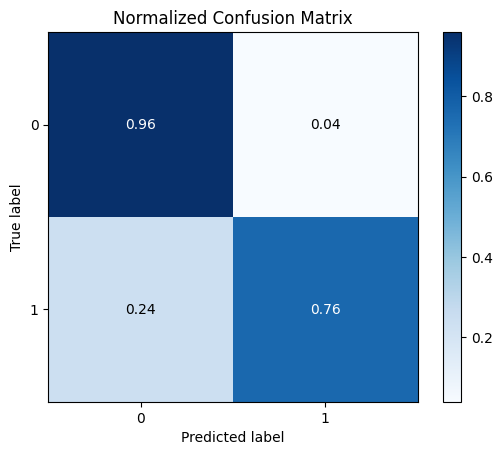

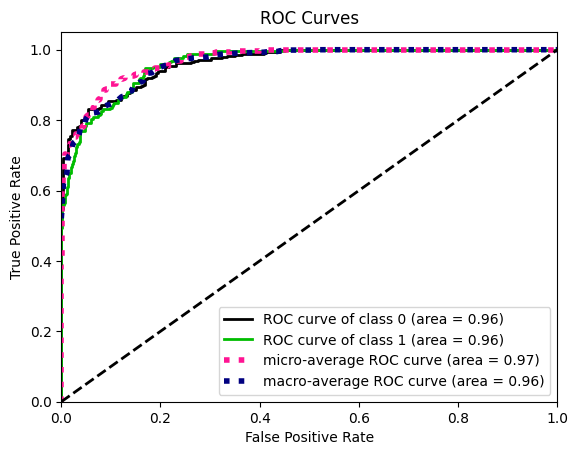

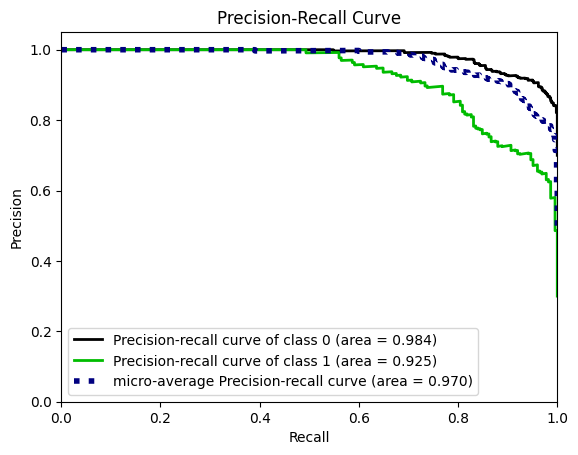

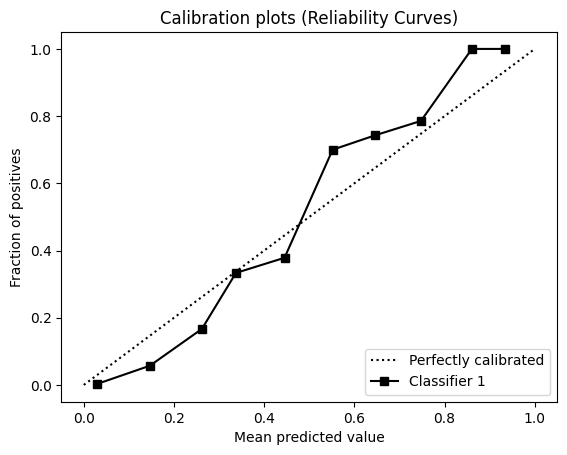

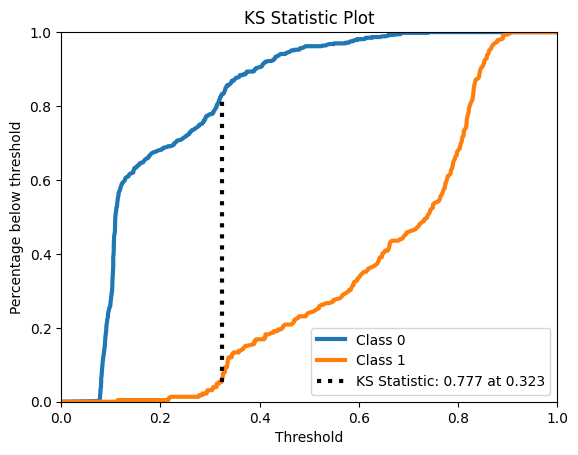

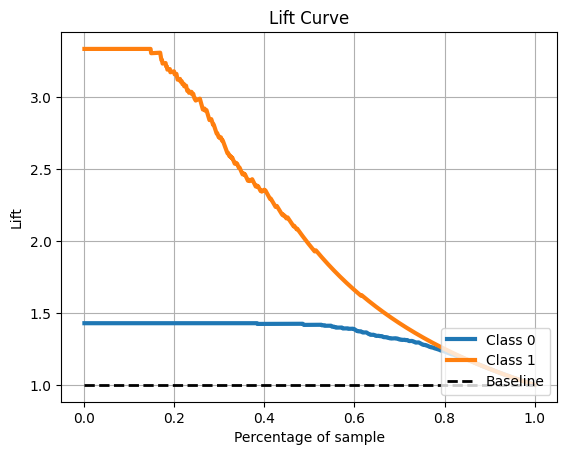

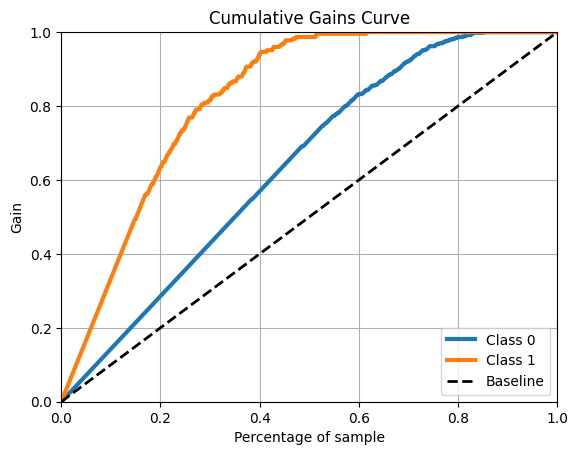

In [118]:
classifier_plots(y_train,y_probas_train1)

In [129]:
y_probas_train2 = clf2.predict_proba(X_train)

In [130]:
probas_list = [y_probas_train1[:,1],y_probas_train2[:,1]]
model_names = ['search1','search2']

In [140]:
plt1 = classifier_plots_int(y_train, probas_list, model_names)

In [144]:
plt1.keys()

dict_keys(['roc', 'pr', 'cal'])

In [145]:
plt1['roc'].show()

In [147]:
plt1['pr'].show()

In [146]:
plt1['cal'].show()

In [148]:
classifier_lift_df(y_train,y_probas_train1[:,1])

,bin,positive_count,total_count,fraction_of_positives,lift
0,0,75,75,1.000000,3.333333
1,1,68,75,0.906667,3.022222
2,2,41,75,0.546667,1.822222
3,3,28,75,0.373333,1.244444
4,4,10,75,0.133333,0.444444
5,5,2,75,0.026667,0.088889
6,6,1,75,0.013333,0.044444
7,7,0,75,0.000000,0.000000
8,8,0,75,0.000000,0.000000
9,9,0,75,0.000000,0.000000


In [151]:
lift_dfs, lift_plot = classifier_lift_plot(y_train,probas_list,model_names,show=True)